### And welcome to Week 4, Day 3 - more LangGraph..

In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langchain.agents import Tool
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain_openai import ChatOpenAI
from typing import TypedDict


In [2]:
# Our favorite first step! Crew was doing this for us, by the way.
load_dotenv(override=True)


True

### First, let's go set up LangSmith!

https://langsmith.com

### Next, here is a useful function in LangChain community:

In [3]:
print("Serper API Key:", os.getenv("SERPER_API_KEY"))

Serper API Key: 44c537c9678b3a96e6d9ade06cb19828e6a2e7c7


In [4]:

from langchain_community.utilities import GoogleSerperAPIWrapper


# Initialize the GoogleSerperAPIWrapper
# It automatically reads the SERPER_API_KEY from environment variables
serper = GoogleSerperAPIWrapper()

# Perform a serper search
query = "what is the capital of France?"
results = serper.run(query)

# Print the results
print(results)


Paris is the capital and largest city of France, with an estimated city population of 2,048,472 in an area of 105.4 km2 (40.7 sq mi), and a metropolitan ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world's most important and ... Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... Paris, the capital and largest city of France, is located in the northern part of the country on the banks of the Seine River. Paris, the capital of France, is often referred to as the "City of Light" and is reno

### Now here is a LangChain wrapper class for converting functions into Tools

In [5]:
from langchain.agents import Tool

tool_search =Tool(
        name="search",
        func=serper.run,
        description="Useful for when you need more information from an online search"
    )



### Now we can try out the tool the langchain way

In [6]:
tool_search.invoke("What is the capital of France?")

'Paris is the capital and largest city of France, with an estimated city population of 2,048,472 in an area of 105.4 km2 (40.7 sq mi), and a metropolitan ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world\'s most important and ... Paris, the capital of France, is often referred to as the "City of Light" and is renowned for its art, culture, and history. Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... Paris, the capital city of France, is often referred to as the “City of Light” (La Vi

# my own function, for fun and practice :D

with `from langchain.agents import Tool`, you can convert any function into a LangChain tool.

In [7]:
from langchain.agents import Tool

def func_print_my_name(name):
    message_ = f"""
    Hello {name}!
    How are you today?
    I hope you have a great day!
    """

    print(message_)
    return message_

tool_print_my_name = Tool(
    name="print_my_name",
    func=func_print_my_name,
    description="print user name in a friendly way"
)

tool_print_my_name.invoke('Ali')


    Hello Ali!
    How are you today?
    I hope you have a great day!
    


'\n    Hello Ali!\n    How are you today?\n    I hope you have a great day!\n    '

### And now let's write a tool ourselves

We'll pick a familiar one

In [8]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})

In [9]:
tool_push = Tool(
        name="send_push_notification",
        func=push,
        description="useful for when you want to send a push notification"
    )

tool_push.invoke("Hello, me")

### Back to the Graph from yesterday

One small change - using TypedDict instead of BaseModel for the State object

When we implement tools, we always need to make 2 changes to the code:

1. Changes to provide the tools to OpenAI in a specific json format

2. Changes to handle the results back: look for the model saying that the `finish_reason=="tool_calls"` and then retrieve the call, run the function, provide the results.

### Bring them together

In [10]:
tools = [tool_search, tool_push]

In [11]:
# Step 1: Define the State object
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [12]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)

## explain `llm.bind_tools`
In LangChain, `llm.bind_tools(tools)` is how you bind (attach) tool definitions to an LLM call so the llm knows aviable tools and it can decide to call them during a conversation. <br>
so for example, if llm does not know an information it cas use search tool or if it needs to send a push notification, it can use another tool to send the notification.


### What `bind_tools` does (high-level)

`bind_tools(tools)`:

1. Registers tool definitions with the LLM  
2. Converts them into OpenAI-compatible tool/function schemas (specific json format)  
3. Returns a **new LLM object** configured with those tools  
4. Enables the model to emit structured **tool calls**


In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini")
query = "what is the population of Calgary in 2025?"
response = llm.invoke(query)
print(response)

content="I can't provide real-time data or future projections beyond my last update in October 2023. However, as of the 2021 Census, Calgary had a population of approximately 1.3 million people. You may want to consult local government resources or demographic studies for population projections for 2025. Alternatively, municipal or provincial statistical agencies often provide such forecasts." additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 18, 'total_tokens': 91, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_ee69c2ef48', 'id': 'chatcmpl-CoElSzvIdCAlxSGPaFFUfYWWWCoKU', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--3991791a-15bd-4a7e-b985-000e7023eb36-0' usage_metadata

In [ ]:
import json
llm_with_tools = llm.bind_tools(tools)
query = "what is the population of Calgary in 2025?"
response = llm_with_tools.invoke(query)
print(response)

content='' additional_kwargs={'tool_calls': [{'id': 'call_5lPOspIXUiYvCkgPRbUateMC', 'function': {'arguments': '{"__arg1":"Calgary population 2025 forecast"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 99, 'total_tokens': 120, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_ee69c2ef48', 'id': 'chatcmpl-CoElVgAqdYNGIevPcPD9KJQS0VAl1', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--66ea48bd-b9ee-429c-8e38-0573e78c9629-0' tool_calls=[{'name': 'search', 'args': {'__arg1': 'Calgary population 2025 forecast'}, 'id': 'call_5lPOspIXUiYvCkgPRbUateMC', 'type': 'tool_call'}] usage_metadata={'input_tokens': 99, 'output_tokens': 21, 'total_tokens': 1

In [15]:
# This is different:

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

In [16]:
# Step 3: Create a Node
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))


# Step 4: Create Edges
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

### explain `ToolNode(tools=tools)`?

`ToolNode` is a **prebuilt LangGraph node** responsible for executing tools requested by an LLM and returning their results back into the graph state.

It acts as the runtime bridge between:
- An **LLM that decides to call a tool**
- Actual **Python functions** that perform real actions

```python
from langgraph.prebuilt import ToolNode, tools_condition
```

---

#### Why `ToolNode` Exists

LLMs can *request* tool usage, but LangGraph does not automatically execute them.

When an LLM produces:
```json
{
  "tool_calls": [
    {
      "name": "search",
      "arguments": {"query": "LangGraph ToolNode"}
    }
  ]
}
```

`ToolNode` is the component that:
- Detects tool calls
- Executes the matching tool (Python functions)
- Injects results back into the graph state



## explain `graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")`?

#### 1. General Structure of `add_conditional_edges`

Conceptually, `add_conditional_edges` means:

> After this node runs, look at the state, evaluate a condition function based on the state, and map (route) execution to the next node based on what the function returns.

##### General form:

```python
graph_builder.add_conditional_edges(
    source_node_name,
    condition_function,
    path_map
)
```

##### Parameters:

| Parameter | Description |
|--------|------------|
| `source_node_name` | The node that just executed |
| `condition_function` | Function that inspects the state and decides routing |
| `path_map` | Maps condition outputs to destination nodes |

---

#### 2. Two Ways to Use `add_conditional_edges`

##### A. Explicit mapping form

```python
graph_builder.add_conditional_edges(
    "chatbot",
    condition_fn,
    {
        "tools": "tools",
        "__end__": "__end__"
    }
)
```

Meaning:
- If `condition_fn(state)` returns `"tools"` → go to `tools`
- If it returns `"__end__"` → stop execution

---

##### B. Shortcut form (used in your code)

```python
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    "tools"
)
```

This is shorthand for:

> If the tools_condition is met (i.e., the condition function and last LLM call signal tool usage), route to `"tools"`.  
> Otherwise, stop execution.

---

#### 3. What is `tools_condition`?

tools_condition is a prebuilt condition function provided by LangGraph.

```python
from langgraph.prebuilt import tools_condition
```

Its responsibility is very specific:

> Determine whether the **last LLM message (AI message) requested tool calls**.

---

##### What `tools_condition` checks internally

1. Looks at `state["messages"]`
2. Extracts the **most recent message**
3. Verifies:
   - The message is from the AI
   - It requested/contained one or more tool_calls: `finish_reason=="tool_calls"`

If both are true, tools should be executed.

---

#### 4. Possible Return Values of `tools_condition`

`tools_condition` does **not** return arbitrary values. It returns routing signals understood by LangGraph.

##### 1. `"tools"`

Returned when:
- The LLM has requested one or more tools

Effect:
```text
Route execution to the "tools" node
```

---

##### 2. `"__end__"`

Returned when:
- The LLM did not request any tools

Effect:
```text
End graph execution
```

---


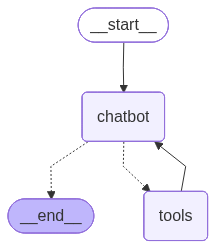

In [17]:
# Step 5: Compile the Graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### That's it! And, let's do this:

In [33]:
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


## OK it's time to add Memory!

### BUT WAIT!

We have this whole Graph maintaining the state and appending to the state.

Why isn't this handling memory?

### This is a crucial point for understanding LangGraph

> A super-step can be considered a single iteration over the graph nodes. Nodes that run in parallel are part of the same super-step, while nodes that run sequentially belong to separate super-steps.


One "Super-Step" of the graph represents one invocation of the graph and passing messages between agents.

In idomatic LangGraph, you call invoke to run your graph for each super-step; for each interaction.

The reducer handles state updates automatically within one super-step, but not between them.

That is what checkpointing achieves.

### Q. why do we need memory and checkpoints in langgraph?
- a conversation consists of muliple graph invocation: each time that you input is a separate invocation.
- every invokation of the graph is independent, and fresh start.
- state and automatic state updates with the reducer function persist information only in one invocation and not between them.
- you add checkpinter (memory) to persist information betweeen multiple invocations in a convesation.

In [20]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

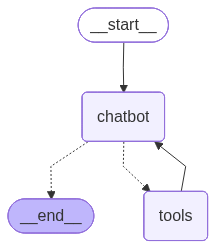

In [21]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### Q. what is `"configurable": {"thread_id": "1"}`?
thread is a thread of conversation. you can have independent threads with different memory and information.

In [ ]:
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='c850d3ff-364f-494b-ba46-39bcee524653')]}
{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='c850d3ff-364f-494b-ba46-39bcee524653'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 89, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_ee69c2ef48', 'id': 'chatcmpl-CoEnGC3Bt4kP827QpFRo9D26YuzZ3', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--6cc6d2ac-3ecf-4e69-9627-f49aac456a0b-0', usage_metadata={'input_tokens': 89, 'output_tokens': 10, 'total_tokens': 99, 'input_token_det

In [2]:
graph.get_state(config)

NameError: name 'graph' is not defined

In [ ]:
# Most recent first

list(graph.get_state_history(config))

### LangGraph gives you tools to set the state back to a prior point in time, to branch off:

```
config = {"configurable": {"thread_id": "1", "checkpoint_id": ...}}
graph.invoke(None, config=config)
```

And this allows you to build stable systems that can be recovered and rerun from any prior checkpoint.

### `SqliteSaver`
now Our memory can be in a SQL database.<br>
not only it persists information between multiple invocations of a conversation, but also it persists the memory locally and you can load that memory every time.

memory that you create with `memory = MemorySaver()` does not persist locally, so it disappears if you restart the cell, but here the memory that you create with `from langgraph.checkpoint.sqlite import SqliteSaver` does not disappear and it is persisted locally.

In [23]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

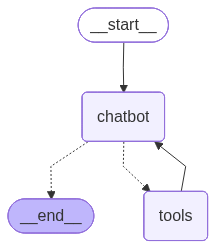

In [24]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))
 

In [ ]:
config = {"configurable": {"thread_id": "4"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='8a892307-f234-453d-a727-d447281ee60b')]}
{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='8a892307-f234-453d-a727-d447281ee60b'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 89, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_ee69c2ef48', 'id': 'chatcmpl-CoErtZdhO0ovMxdpIVUjlwInLyCYE', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--dd479f71-95b1-4a9a-994f-9c54fd880e06-0', usage_metadata={'input_tokens': 89, 'output_tokens': 10, 'total_tokens': 99, 'input_token_det